# Using three different models to detect anomalies from FinBIF specimen data

In [1]:
import os
import warnings
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import helpers
from joblib import Parallel, delayed
from sklearn.model_selection import StratifiedShuffleSplit


warnings.filterwarnings('ignore')

In [8]:
"""
Read the data. The geopackage has 289 000 YKJ squares (10 km x 10 km grid polygons). 
Each of them contain:
    - the bird information:
        - atlas class value,
        - ID,
        - name
        - atlas activity category
    - CORINE land cover proportions
    - temperature, tree volume and height
    - YKJ coordinates (ykj_n and ykj_e)
    - coastline length in a square

In finland, there are 3816 YKJ squares in total, so this geopackage has multiple overlapping polygons, one for each bird.
"""
gdf = gpd.read_file('data_obs/YKJ_env_with_birds.gpkg')
gdf_new_grids = gpd.read_file('data_obs/YKJ_env_no_birds.gpkg')

csv_file = 'model_statistics.csv'
if os.path.isfile(csv_file):
    os.remove(csv_file)


In [9]:
# Define feature columns (environment, habitat and coordinates)
features = ['coastline', 'temp', 'dem', 'Urban', 'Park', 'Rural', 'Forest', 'Open_forest', 'Fjell', 'Open_area', 'Wetland', 'Open_bog', 'Freshwater', 'Marine', 'ykj_n', 'ykj_e', 'tree_vol']

In [10]:
# Hyperparameter grids to optimize model parameters
param_grids = {
    'rf': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    },
    'gb': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [5, 10, 20],
        'class_weight': ['balanced']
    },
    'me': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['balanced']
    }
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

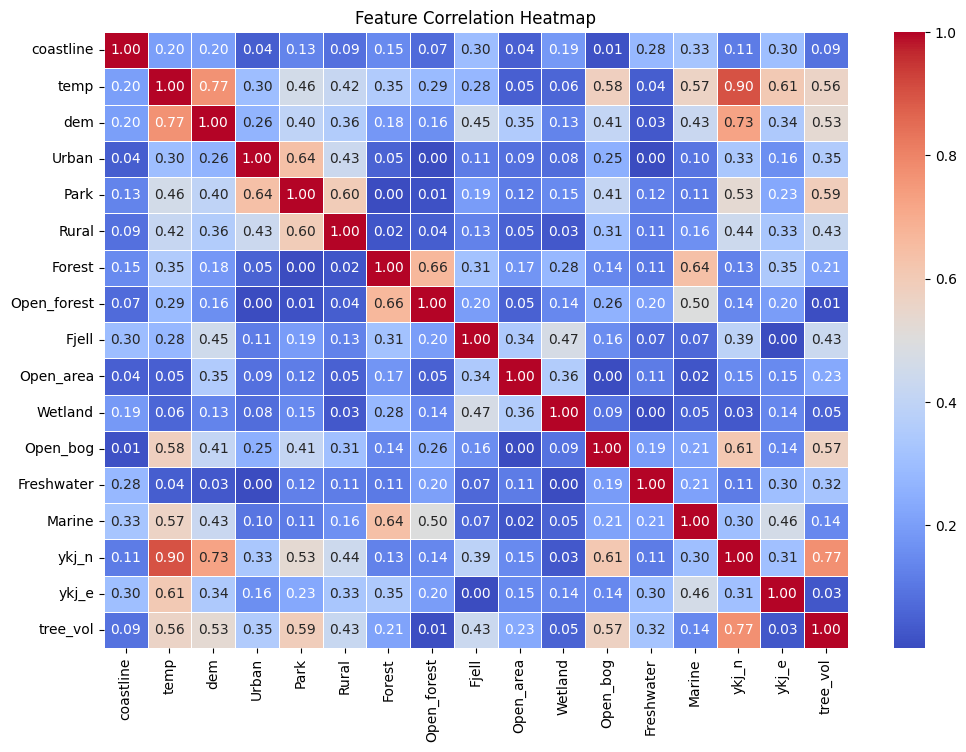

Highly correlated features (correlation > 0.8) to drop: ['ykj_n']


In [11]:
# Find and remove highly correlated features
correlated_features = helpers.find_highly_correlated_features(gdf_new_grids[features], threshold=0.9)

# drop correlated features from the features
features = [f for f in features if f not in correlated_features]

Skipping bird aavikkotasku due to insufficient data.
Processing bird: alli
Number of present data: 38
Number of absent data: 3778
ROC AUC Random Forest: 0.9841269841269841
ROC AUC Histogram Gradient Boosting: 0.9737854737854739
ROC AUC MaxEnt: 0.991662658329325


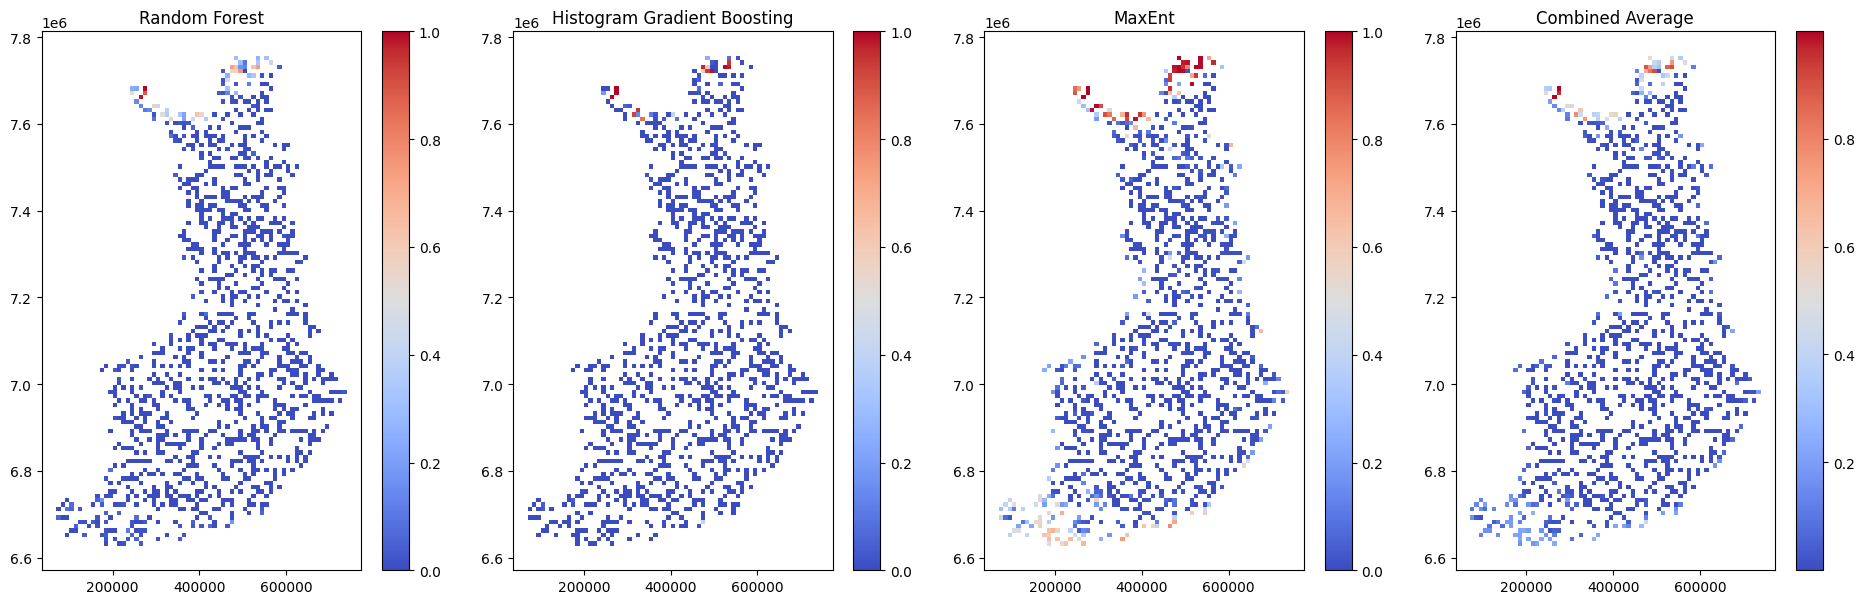

In [12]:
# Process each bird separately
for bird_name, bird_data in gdf.groupby('species_name'):

    if len(bird_data) < 10:
        print(f'Skipping bird {bird_name} due to insufficient data. (Only {len(bird_data)} squares)')
        continue

    print(f'Processing bird: {bird_name}')
    
    # From new grid squares select only squares that are not in bird data
    bird_data = pd.concat([bird_data, gdf_new_grids[~gdf_new_grids['coordinates'].isin(bird_data['coordinates'])]]).reset_index(drop=True)

    # select columns for precense data
    gdf_precense = bird_data[
        (bird_data['atlas_class_value'] == 'Varma pesintä') | 
        (bird_data['atlas_class_value'] == 'Todennäköinen pesintä')
    ]

    # select columns for absence data
    gdf_absence = bird_data[
        (bird_data['atlas_class_value'] == 'Epätodennäköinen pesintä') |
        (bird_data['atlas_class_value'] == 'Mahdollinen pesintä') |
        (bird_data['atlas_class_value'].isnull())
    ]

    print('Number of present data:', len(gdf_precense))
    print('Number of absent data:', len(gdf_absence))

    if len(gdf_precense) < 10 or len(gdf_absence) < 10:
        print('Skipping bird due to insufficient data.')
        continue

    # Combine presence and absence data into a single GeoDataFrame. Add column 'class'
    merged = helpers.stack_geodataframes(gdf_precense, gdf_absence, add_class_label=True)

    # Prepare feature matrices and target variables
    X = merged[features]
    y = merged['class']
    weights = merged['weights']

    # Split data into training and testing sets
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, test_idx = next(splitter.split(X, y))

    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    weights_train = weights.iloc[train_idx]
    weights_test =  weights.iloc[test_idx]
    
    X_test_indices = X_test.index if isinstance(X, pd.DataFrame) else X.iloc[y_test.index].index

    # Normalize based on the training set
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) 

    # Define the models to use
    models_to_train = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', HistGradientBoostingClassifier(random_state=42)),
        ('me', LogisticRegression(random_state=42))
    ]

    # Perform parallelized grid search for each model
    results = Parallel(n_jobs=-1)(
        delayed(helpers.perform_grid_search)(
            model, param_grids[model_name], X_train, y_train, weights_train, cv
        ) for model_name, model in models_to_train
    )

    best_rf, best_gb, best_me = results

    predictions_rf = best_rf.predict(X_test)
    predictions_gb = best_gb.predict(X_test)
    predictions_me = best_me.predict(X_test)

    probs_rf = best_rf.predict_proba(X_test)[:, 1]
    probs_gb = best_gb.predict_proba(X_test)[:, 1]
    probs_me = best_me.predict_proba(X_test)[:, 1]

    rf_stats = helpers.get_statistics(best_rf, "Random Forest", bird_name, y_test, predictions_rf, probs_rf)
    gb_stats = helpers.get_statistics(best_gb, "Histogram Gradient Boosting", bird_name, y_test, predictions_gb, probs_gb)
    me_stats = helpers.get_statistics(best_me, "MaxEnt", bird_name, y_test, predictions_me, probs_me)

    helpers.save_results_to_csv(csv_file, rf_stats)
    helpers.save_results_to_csv(csv_file, gb_stats)
    helpers.save_results_to_csv(csv_file, me_stats)

    roc_auc_rf = rf_stats.get('ROC-AUC')
    roc_auc_gb = gb_stats.get('ROC-AUC')
    roc_auc_me = me_stats.get('ROC-AUC')

    print(f'ROC AUC Random Forest: {roc_auc_rf}')
    print(f'ROC AUC Histogram Gradient Boosting: {roc_auc_gb}')
    print(f'ROC AUC MaxEnt: {roc_auc_me}')
    
    # results is the new_grid_squares polygons that are identical with X_test
    results = merged.iloc[X_test_indices].copy() 
    
    results['rf_probability'] = helpers.normalize(probs_rf)
    results['gb_probability'] = helpers.normalize(probs_gb)
    results['me_probability'] = helpers.normalize(probs_me)

    results['probability'] = results[['rf_probability', 'gb_probability', 'me_probability']].mean(axis=1)

    helpers.plot_results(results, bird_name, save=False)

    # save gpkg with the result columns
    results.to_file(f'data_results/geopackages_YKJ3/{bird_name}.gpkg', driver='GPKG')

    break # Remove this line to process all birds
